# Isolation Forest for anomaly detection (With Labels)

### Import Library

In [96]:
import os
import sys
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Go to root dir
# sys.path.append(os.path.abspath(".."))

from src.load_data import load_sheet, clean_sheet_with_label
from src.isolation_forest import plot_sub_dataset 
from src.supervised_isolation_forest import create_pipeline, convert_labels_to_binary

%load_ext autoreload
%matplotlib
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: module://matplotlib_inline.backend_inline


In [59]:
internal_df, sheet1 = load_sheet("Electroplate Experiments Data JUN_JUL", "vary_internal_table")
internal_df = clean_sheet_with_label(internal_df)
# two_side_plate, sheet2 = load_sheet("Electroplate Experiments Data JUN_JUL", "2 side Experimental Result")
# two_side_plate = clean_sheet_with_label(two_side_plate)
august_df, sheet3 = load_sheet("Electroplating Experiments Data August", "Sheet1")
august_df = clean_sheet_with_label(august_df)
september_df, sheet4 = load_sheet("Electroplating Experiments Data September", "Sheet1")
september_df = clean_sheet_with_label(september_df)

In [60]:
df = pd.concat([internal_df, august_df, september_df]).reset_index(drop=True)
df['index'] = df.groupby('run_id').cumcount() + 1
time_index_series = df.pop('index')
df.insert(0, 'index', time_index_series)

In [61]:
SENSOR_FEATURES = ["conductivity", "temperature", "pH",	"voltage"]
TRAIN_RUNS = ['JUL_22_1','JUL_22_2', 'JUL_22_3', 'JUL_22_4', 'JUL_22_5', 'JUL_22_6','JUL_22_7', 'JUL_22_8', 'JUL_22_9', 
			  'JUL_23_1', 'JUL_23_2', 'JUL_23_3', 'JUL_23_4', 'JUL_23_5']
# TEST_RUNS = ['JUL_24_1', 'JUL_24_2',
#        'JUL_24_3', 'JUL_24_4', 'JUL_24_5', 'JUL_24_6', 'JUL_24_7',
#        'JUL_24_8', 'JUL_24_9', 'JUL_24_10']

# NORMAL_RUNS = ['JUL_22_4', 'JUL_22_5', 'JUL_22_7']
# NORMAL_CONDUCTIVITY_RUNS = ['JUL_22_1','JUL_22_2', 'JUL_22_4', 'JUL_22_5', 'JUL_22_7']

In [62]:
df_train = df[df['run_id'].isin(TRAIN_RUNS)].reset_index(drop=True)
df_train.index = df_train['run_id'].index + 1
df_train

,index,run_id,timestamp,time,time_total,area,cathode,anode,mass_SLS,mass_NISO4,...,pH,Anomaly P,temperature,Anomaly T,voltage,Anomaly V,current,amp_hour,deposition_rate,bath_id
1,1,JUL_22_1,2025-07-22 13:17:40,2,2,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.70,N,3.639,N,2.342,0.002,0.6329,Bath_3
2,2,JUL_22_1,2025-07-22 13:17:42,2,4,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.70,N,3.705,N,2.342,0.004,0.6329,Bath_3
3,3,JUL_22_1,2025-07-22 13:17:44,2,6,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.71,N,3.702,N,2.342,0.006,0.6329,Bath_3
4,4,JUL_22_1,2025-07-22 13:17:46,2,8,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.68,N,3.673,N,2.342,0.008,0.6329,Bath_3
5,5,JUL_22_1,2025-07-22 13:17:49,2,10,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.69,N,3.668,N,2.342,0.010,0.6329,Bath_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8366,594,JUL_23_5,2025-07-23 14:18:59,2,16732,67,Brass,Nickel,0.35,270.0,...,4.21,N,49.77,N,3.437,V2,2.343,10.890,0.6301,Bath_3
8367,595,JUL_23_5,2025-07-23 14:19:01,2,16734,67,Brass,Nickel,0.35,270.0,...,4.21,N,49.75,N,3.493,V2,2.343,10.892,0.6301,Bath_3
8368,596,JUL_23_5,2025-07-23 14:19:03,2,16736,67,Brass,Nickel,0.35,270.0,...,4.21,N,49.75,N,3.508,V2,2.343,10.893,0.6301,Bath_3
8369,597,JUL_23_5,2025-07-23 14:19:05,2,16738,67,Brass,Nickel,0.35,270.0,...,4.21,N,49.73,N,3.564,V2,2.343,10.894,0.6301,Bath_3


In [63]:
print(f'-------------------df---------------------------')
print(f'Anomaly C type: {df['Anomaly C'].unique()}')
print(f'Anomaly P type: {df['Anomaly P'].unique()}')
print(f'Anomaly T type: {df['Anomaly T'].unique()}')
print(f'Anomaly V type: {df['Anomaly V'].unique()}')
print(f'-------------------Train df---------------------')
print(f'Anomaly C type: {df_train['Anomaly C'].unique()}')
print(f'Anomaly P type: {df_train['Anomaly P'].unique()}')
print(f'Anomaly T type: {df_train['Anomaly T'].unique()}')
print(f'Anomaly V type: {df_train['Anomaly V'].unique()}')
# print(f'-------------------Test df----------------------')
# print(f'Anomaly C type: {df_test['Anomaly C'].unique()}')
# print(f'Anomaly P type: {df_test['Anomaly P'].unique()}')
# print(f'Anomaly T type: {df_test['Anomaly T'].unique()}')
# print(f'Anomaly V type: {df_test['Anomaly V'].unique()}')

-------------------df---------------------------
Anomaly C type: ['' 'N' 'C3' 'C1' 'C2' None]
Anomaly P type: ['' 'N' None]
Anomaly T type: ['' 'N' None]
Anomaly V type: ['' 'N' 'V1' 'V2' None]
-------------------Train df---------------------
Anomaly C type: ['N' 'C3' 'C1' 'C2']
Anomaly P type: ['N']
Anomaly T type: ['N']
Anomaly V type: ['N' 'V1' 'V2']


In [64]:
PARAM_RANGE = {
	"conductivity": [50, 60], 
	"temperature": [49, 51], 
	"pH": [3.7, 4.5],
	"voltage": [3, 5]
}

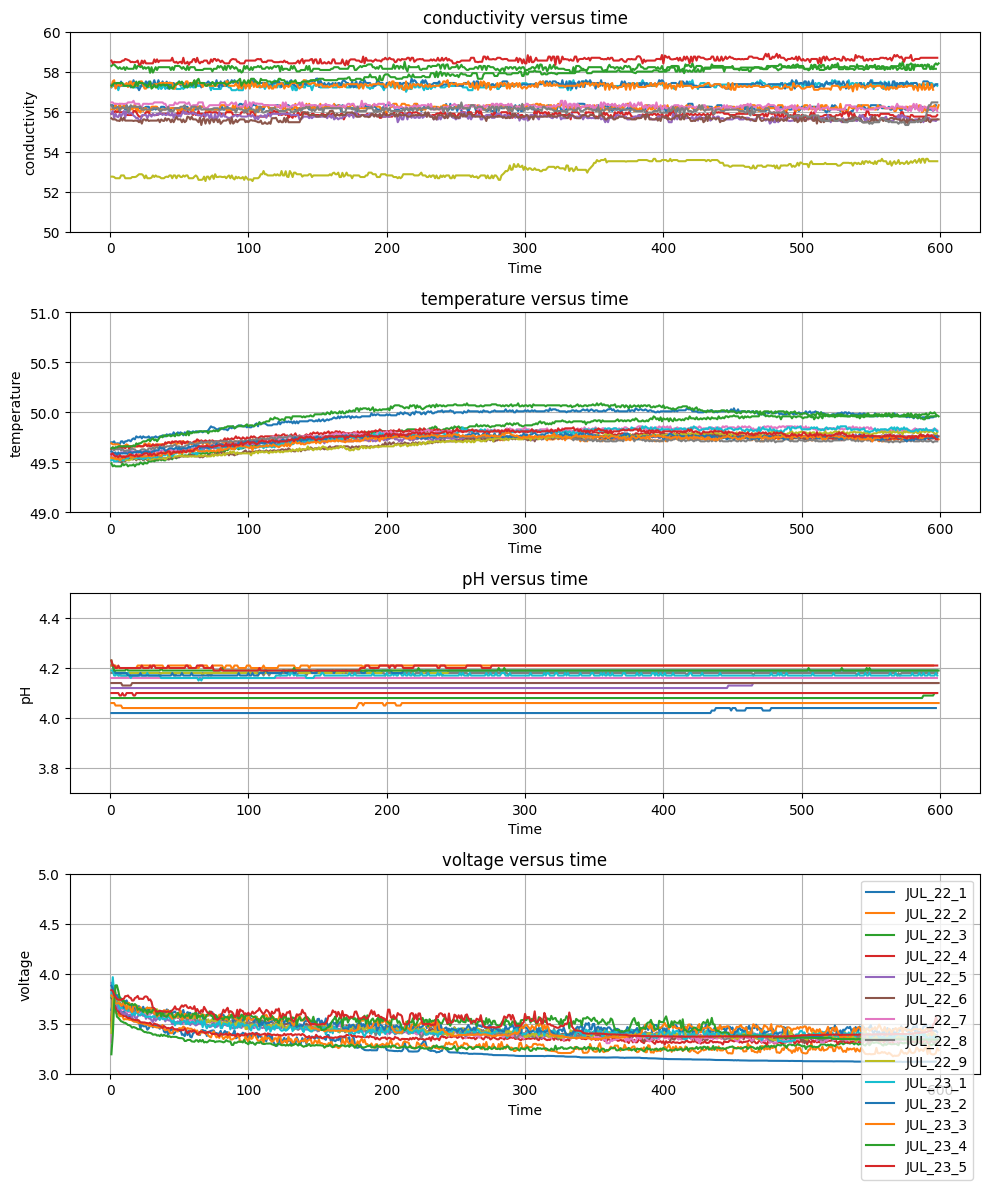

In [65]:
plot_sub_dataset(df_train, PARAM_RANGE)

In [66]:
# df_test = df[df['run_id'].isin(TEST_RUNS)].reset_index(drop=True)
# df_test

In [75]:
filtered_train_df = df_train[['run_id', 'conductivity', 'Anomaly C','pH', 'temperature', 'voltage', 'index', 'timestamp']]
# filtered_test_df = df_test[['run_id', 'conductivity', 'pH', 'temperature', 'voltage', 'index', 'timestamp']]

In [76]:
filtered_train_df.head(5)

,run_id,conductivity,Anomaly C,pH,temperature,voltage,index,timestamp
1,JUL_22_1,56.32,N,4.02,49.70,3.639,1,2025-07-22 13:17:40
2,JUL_22_1,56.32,N,4.02,49.70,3.705,2,2025-07-22 13:17:42
3,JUL_22_1,56.17,N,4.02,49.71,3.702,3,2025-07-22 13:17:44
4,JUL_22_1,56.17,N,4.02,49.68,3.673,4,2025-07-22 13:17:46
5,JUL_22_1,56.17,N,4.02,49.69,3.668,5,2025-07-22 13:17:49


In [69]:
# filtered_test_df.head(5)

In [77]:
anomaly_pipeline = create_pipeline()
anomaly_pipeline

,steps,"[('feature_generator', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sensor_cols,"['conductivity', 'temperature', ...]"
,lag_steps,"[1, 2, ...]"
,rolling_window,1
,rolling_min_periods,1
,copy,True
,with_mean,True
,with_std,True


In [85]:
ANOMALY_LABEL_COL = 'Anomaly C' # The new column containing 0 (Normal) or 1 (Anomaly)
BINARY_LABEL_COL = 'True_Anomaly_C'
filtered_train_df[BINARY_LABEL_COL] = convert_labels_to_binary(filtered_train_df[ANOMALY_LABEL_COL])
X_full = filtered_train_df.copy()
X_processed = anomaly_pipeline.named_steps['scaler'].fit_transform(
    anomaly_pipeline.named_steps['feature_generator'].fit_transform(X_full)
)
X_processed

/var/folders/fd/5wd3mqp94mz3pq009lxrc6yw0000gn/T/ipykernel_61461/2864022351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_df[BINARY_LABEL_COL] = convert_labels_to_binary(filtered_train_df[ANOMALY_LABEL_COL])


array([[-0.33187189, -2.18487647, -0.606756  , ...,  0.        ,
         1.85807669,  0.        ],
       [-0.33187189, -2.18487647, -0.606756  , ...,  0.        ,
         1.53071253,  0.        ],
       [-0.33187189, -2.18487647, -0.51797296, ...,  0.        ,
         1.62164702,  0.        ],
       ...,
       [ 1.59764764,  1.17275558, -0.25162385, ...,  0.        ,
         0.95782524,  0.        ],
       [ 1.59764764,  1.17275558, -0.42918993, ...,  0.        ,
         1.46705838,  0.        ],
       [ 1.59764764,  1.17275558, -0.42918993, ...,  0.        ,
         1.15788112,  0.        ]], shape=(8230, 29))

In [86]:
anomaly_pipeline.fit(filtered_train_df)

,steps,"[('feature_generator', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sensor_cols,"['conductivity', 'temperature', ...]"
,lag_steps,"[1, 2, ...]"
,rolling_window,1
,rolling_min_periods,1
,copy,True
,with_mean,True
,with_std,True


In [87]:
# We use the decision_function: lower score means higher anomaly likelihood
raw_scores = anomaly_pipeline.named_steps['model'].decision_function(X_processed)

In [90]:
ANOMALY_LABEL_COL = 'Anomaly C' # The new column containing 0 (Normal) or 1 (Anomaly)
BINARY_LABEL_COL = 'True_Anomaly_C'
# C. Align True Labels (y_true) with the processed data
retained_index = anomaly_pipeline.named_steps['feature_generator'].retained_index_
y_true_processed = filtered_train_df.loc[retained_index, BINARY_LABEL_COL].values

In [91]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve

# D. Find the Optimal Threshold (Maximizing F1-Score)
# We need to invert the score: Isolation Forest score is *lower* for anomalies.
# Let's check a wide range of thresholds
precision, recall, thresholds = precision_recall_curve(y_true_processed, -raw_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6) # Added epsilon to prevent division by zero

# Find the threshold that maximizes the F1-score
best_threshold_index = np.argmax(f1_scores)
best_f1 = f1_scores[best_threshold_index]
best_threshold = thresholds[best_threshold_index]

# E. Apply the Optimal Threshold for Final Prediction
# Note: We use -raw_scores > best_threshold because -raw_scores is higher for anomalies (1)
y_pred_optimal = (-raw_scores > best_threshold).astype(int) 

# F. Calculate Final Metrics
cm = confusion_matrix(y_true_processed, y_pred_optimal)
pr = precision_score(y_true_processed, y_pred_optimal)
re = recall_score(y_true_processed, y_pred_optimal)
roc_auc = roc_auc_score(y_true_processed, -raw_scores)

print("--- Supervised Anomaly Detection Analysis ---")
print(f"Total Processed Datapoints: {len(y_true_processed)}")
print(f"True Anomalies (Label=1): {y_true_processed.sum()}")
print("-" * 40)
print("Optimal Threshold Analysis:")
print(f"Optimal Score Threshold (for -Raw Score): {best_threshold:.4f}")
print(f"Best F1-Score achieved: {best_f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f} (Model's overall discriminative power)")
print("-" * 40)
print("Evaluation Metrics at Optimal Threshold:")
print(f"Precision (Accuracy of 'Anomalies'): {pr:.4f}")
print(f"Recall (Capture Rate of True Anomalies): {re:.4f}")
print("\nConfusion Matrix (True vs. Predicted):")
print(cm)
print("Rows are True Labels (0, 1), Columns are Predicted Labels (0, 1)")

--- Supervised Anomaly Detection Analysis ---
Total Processed Datapoints: 8230
True Anomalies (Label=1): 4141
----------------------------------------
Optimal Threshold Analysis:
Optimal Score Threshold (for -Raw Score): -0.1151
Best F1-Score achieved: 0.6695
ROC-AUC Score: 0.6013 (Model's overall discriminative power)
----------------------------------------
Evaluation Metrics at Optimal Threshold:
Precision (Accuracy of 'Anomalies'): 0.5031
Recall (Capture Rate of True Anomalies): 0.9998

Confusion Matrix (True vs. Predicted):
[[   0 4089]
 [   1 4140]]
Rows are True Labels (0, 1), Columns are Predicted Labels (0, 1)


/var/folders/fd/5wd3mqp94mz3pq009lxrc6yw0000gn/T/ipykernel_61461/3470480360.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_df['Anomaly_Label'] = optimal_results
/var/folders/fd/5wd3mqp94mz3pq009lxrc6yw0000gn/T/ipykernel_61461/3470480360.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_df['True_Label'] = filtered_train_df[BINARY_LABEL_COL]
/var/folders/fd/5wd3mqp94mz3pq009lxrc6yw0000gn/T/ipykernel_61461/3470480360.py:17: SettingWithCopyWarning: 
A value is trying to be

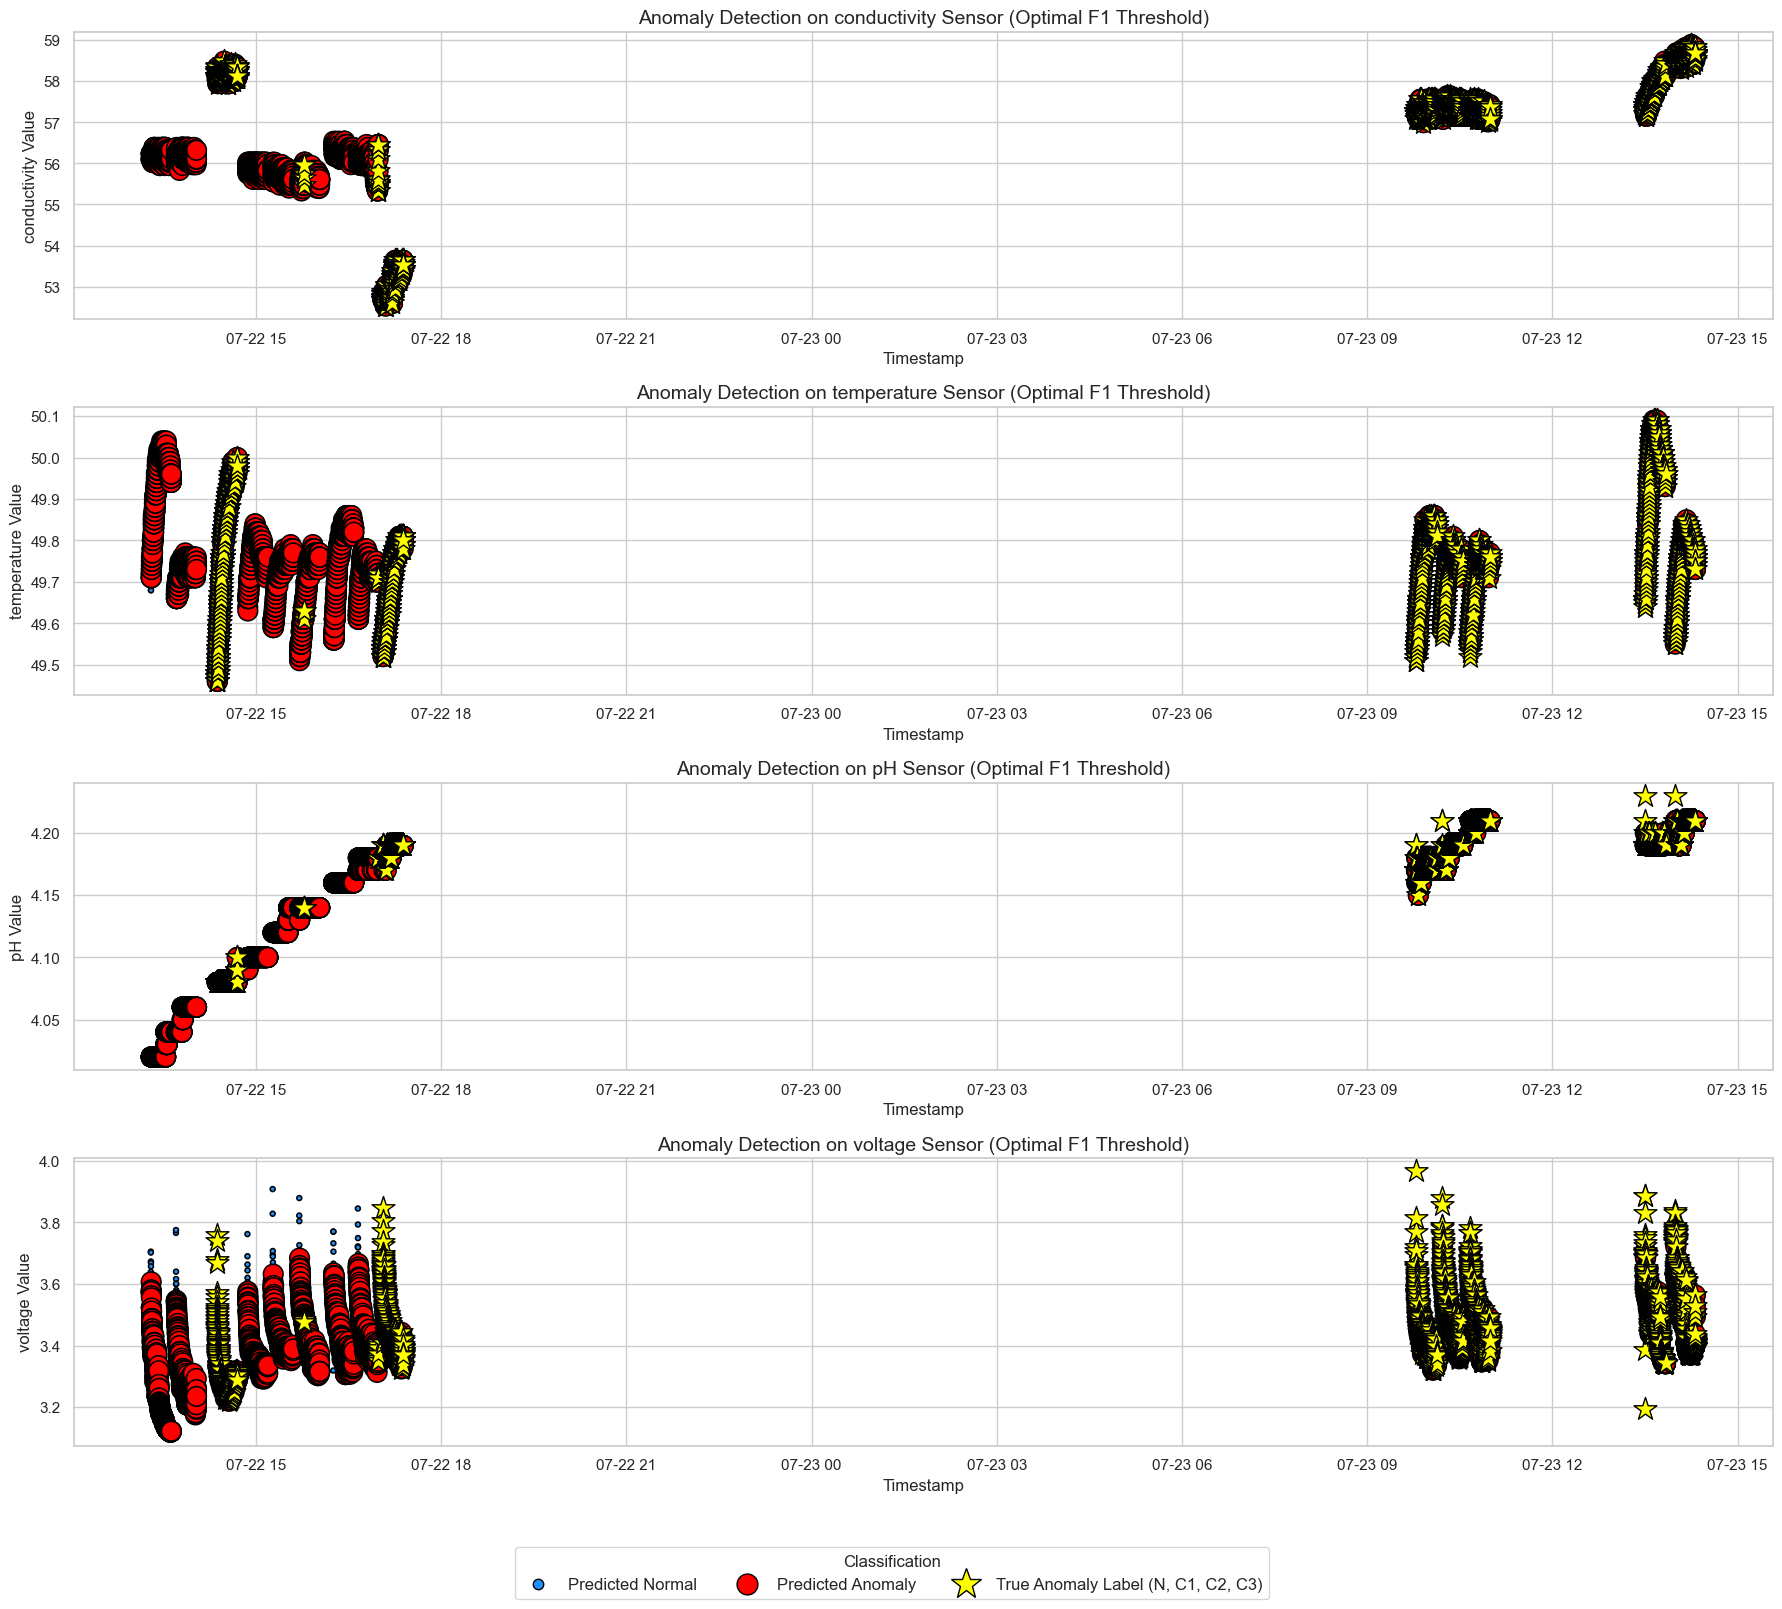

In [100]:
# ----------------------------------------------------------------------
# --- 4. Visualization of Supervised Results
# ----------------------------------------------------------------------

SENSOR_FEATURES = ["conductivity", "temperature", "pH",	"voltage"]

# G. Map Optimal Prediction Back to DataFrame for Visualization
optimal_results = pd.Series(0, index=filtered_train_df.index)
optimal_results.loc[retained_index] = y_pred_optimal 

filtered_train_df['Anomaly_Label'] = optimal_results
filtered_train_df['True_Label'] = filtered_train_df[BINARY_LABEL_COL]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 16)) 

filtered_train_df['Anomaly_Label_Str'] = filtered_train_df['Anomaly_Label'].astype(str)

for i, sensor in enumerate(SENSOR_FEATURES):
    plt.subplot(len(SENSOR_FEATURES), 1, i + 1)
    
    sns.scatterplot(
        data=filtered_train_df,
        x='timestamp',
        y=sensor,
        hue='Anomaly_Label_Str', 
        palette={'0': 'dodgerblue', '1': 'red'}, 
        size='Anomaly_Label_Str',
        sizes={'0': 50, '1': 200}, 
        style='Anomaly_Label_Str',
        markers={'0': '.', '1': 'o'},
        edgecolor='black',
        zorder=5, 
        legend=False 
    )

    true_anomalies = filtered_train_df[filtered_train_df['True_Label'] == 1]
    plt.scatter(
        true_anomalies['timestamp'],
        true_anomalies[sensor],
        marker='*', 
        color='yellow',
        s=300, 
        label='True Anomaly Label',
        edgecolor='black',
        zorder=6 
    )

    plt.title(f'Anomaly Detection on {sensor} Sensor (Optimal F1 Threshold)', fontsize=14)
    plt.xlabel('Timestamp')
    plt.ylabel(f'{sensor} Value')

# Add a single shared legend at the bottom
legend_elements = []

for label_str in ['0', '1']:
    h = plt.Line2D([0], [0], marker={'0': '.', '1': 'o'}[label_str], color='w', 
                   markerfacecolor={'0': 'dodgerblue', '1': 'red'}[label_str], 
                   markeredgecolor='black', markersize=10, 
                   label={'0': 'Predicted Normal', '1': 'Predicted Anomaly'}[label_str])
    legend_elements.append(h)

h_true = plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='yellow', 
                    markeredgecolor='black', markersize=15, 
                    label='True Anomaly Label (N, C1, C2, C3)')
legend_elements.append(h_true)

plt.figlegend(handles=legend_elements, title='Classification', loc='lower center', ncol=3, 
              fontsize=12, markerscale=1.5, bbox_to_anchor=(0.5, -0.01))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()